<a href="https://colab.research.google.com/github/AIFFEL-GN-2nd/TotochTeam3/blob/main/ex3_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
!python --version

Thu Oct  7 17:29:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    39W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -U albumentations

# 1. Custom Dataset과 DataLoader 만들기

Kaggle의 [Dogs vs. Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data)에서 데이터셋을 내려받습니다.  
(제 구글드라이브에 이미 파일을 업로드해두었으므로, 아래 명령어를 통해 바로 내려받을 수 있습니다.)

```
$ pip install gdown
$ gdown https://drive.google.com/uc?id=1RBVuPoOFTTSGioAOsUzy76wPSFg3hw5J
$ gdown https://drive.google.com/uc?id=1AIIsrHpftkGEw0-8iKoLLrPoRCNWHq5R
$ unzip -q ./train.zip
!unzip -q ./test1.zip
```

## 1-1. 데이터셋 확인

In [3]:
# 데이터셋의 압축을 풀어보자.

!pip install gdown
!gdown https://drive.google.com/uc?id=1RBVuPoOFTTSGioAOsUzy76wPSFg3hw5J
!gdown https://drive.google.com/uc?id=1AIIsrHpftkGEw0-8iKoLLrPoRCNWHq5R
!unzip -q ./train.zip
!unzip -q ./test1.zip

Downloading...
From: https://drive.google.com/uc?id=1RBVuPoOFTTSGioAOsUzy76wPSFg3hw5J
To: /content/train.zip
100% 570M/570M [00:02<00:00, 236MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AIIsrHpftkGEw0-8iKoLLrPoRCNWHq5R
To: /content/test1.zip
100% 284M/284M [00:01<00:00, 189MB/s]
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
# train, test 데이터의 갯수를 확인해보자.

import os
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import models

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [5]:
train_files = os.listdir("./train")
test_files = os.listdir("./test1")

print(len(train_files))
print(len(test_files))

25000
12500


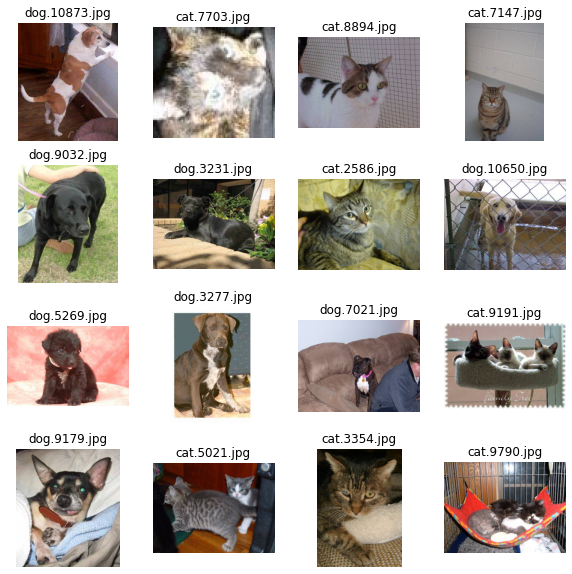

In [6]:
# train data가 어떻게 구성되어있는지 확인하자.
train_root = "./train"

fig = plt.figure(figsize=(10, 10))
for i, f in enumerate(train_files[:16], 1):
    file_path = os.path.join(train_root, f)
    img_bgr = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    ax = fig.add_subplot(4, 4, i)
    ax.set_title(f)
    ax.axis("off")
    
    plt.imshow(img_rgb)
    
plt.show()

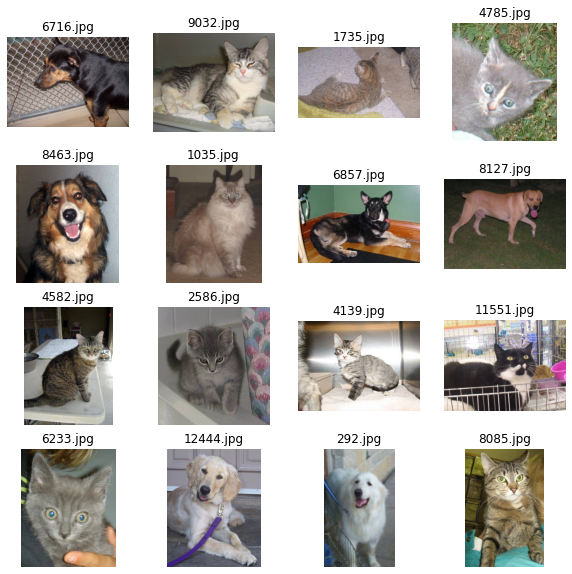

In [7]:
# test data가 어떻게 구성되어있는지 확인하자.
test_root = "./test1"

fig = plt.figure(figsize=(10, 10))
for i, f in enumerate(test_files[:16], 1):
    file_path = os.path.join(test_root, f)
    img_bgr = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    ax = fig.add_subplot(4, 4, i)
    ax.set_title(f)
    ax.axis("off")
    
    plt.imshow(img_rgb)

### 정리

#### 데이터 갯수
- train dataset : 25000장
- test datset : 12500장

#### train 데이터 형태
- 파일 경로에 class명(dog/cat)이 포함되어 있음

#### test 데이터 형태
- 파일마다 numbering이 되어있음

## 1-2. Custom Dataset class 정의

파이토치 튜토리얼에서 Custom Dataset class는 다음과 같다.

```python
class CustomImageDataset(Dataset):
    def __init__(self):
        ...
        
    def __len__(self):
        ...

    def __getitem__(self):
        ...
```

`__init__`
- image와 label의 경로와 transform 등을 설정합니다.

`__len__`
- 데이터셋의 샘플 개수를 반환합니다.

`__getitem__`
- 데이터셋에서 데이터를 불러옵니다.

In [8]:
# Custom Dataset 클래스를 정의하자
# 이미지 파일 경로, 레이블 정보, transform을 입력으로 받는다고 가정하자.

class DogCatDataset(Dataset):
    
    def __init__(self, data_dir, file_list, label_list=None, train=True, transform=None):
        self.data_dir = data_dir
        self.file_list = file_list
        self.transform = transform
        self.train = train
        if self.train:
            self.label_list = label_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.data_dir, self.file_list[idx]), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
            
        if self.train:
            # image, label
            return image, self.label_list[idx]
        else:
            # image, test file number
            return image, self.file_list[idx][:-4]

## 1-3. Dataset 생성

In [9]:
# train file의 label을 만들자 (cat: 0, dog: 1)

train_files = sorted(os.listdir("./train"))
train_labels = [0 if "cat" in f else 1 for f in train_files]

print(len(train_files), len(train_labels))

25000 25000


In [10]:
# train set을 train과 validation set으로 나누자

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, stratify=train_labels, random_state=42
)

# 잘 나누어졌는지 확인
print(len(train_files), len(train_labels), train_labels.count(0), train_labels.count(1))
print(len(val_files), len(val_labels), val_labels.count(0), val_labels.count(1))

18750 18750 9375 9375
6250 6250 3125 3125


In [11]:
# transform을 정의하자.

train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

eval_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [12]:
# 이제 train, valid dataset을 만들 수 있다.

train_dataset = DogCatDataset(data_dir="./train",
                              file_list=train_files,
                              label_list=train_labels,
                              train=True,
                              transform=train_transform)

val_dataset = DogCatDataset(data_dir="./train",
                            file_list=val_files,
                            label_list=val_labels,
                            train=True,
                            transform=eval_transform)

In [13]:
# 동일한 방식으로, test dataset도 만들어주자.

test_files = sorted(os.listdir("./test1"))
test_dataset = DogCatDataset(data_dir="./test1",
                             file_list=test_files,
                             train=False,
                             transform=eval_transform)

## 1-4. DataLoader 생성

In [14]:
# DataLoader를 만들어보자.

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0])


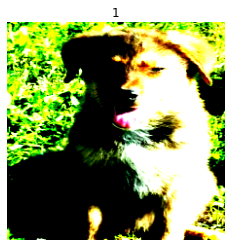

In [15]:
# train_loader가 잘 동작하는지 테스트해보자.

images, labels = next(iter(train_loader))
print(images.shape)
print(labels)

plt.imshow(images[0].permute(1, 2, 0))
plt.title(labels[0].item())
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1])


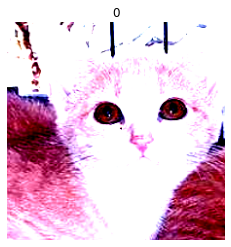

In [16]:
# val_loader가 잘 동작하는지 테스트해보자.

images, labels = next(iter(valid_loader))
print(images.shape)
print(labels)

plt.imshow(images[0].permute(1, 2, 0))
plt.title(labels[0].item())
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
('1', '10', '100', '1000', '10000', '10001', '10002', '10003', '10004', '10005', '10006', '10007', '10008', '10009', '1001', '10010', '10011', '10012', '10013', '10014', '10015', '10016', '10017', '10018', '10019', '1002', '10020', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '1003', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '1004', '10040', '10041', '10042', '10043', '10044', '10045', '10046', '10047', '10048', '10049', '1005', '10050', '10051', '10052', '10053', '10054')


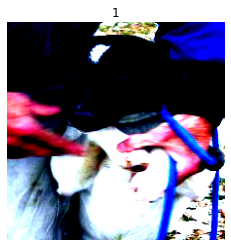

In [17]:
# test_loader가 잘 동작하는지 테스트해보자.

images, labels = next(iter(test_loader))
print(images.shape)
print(labels)

plt.imshow(images[0].permute(1, 2, 0))
plt.title(labels[0])
plt.axis("off")
plt.show()

# 2. Torchvision의 model 사용하기

In [18]:
def train_loop(data_loader, model, loss_fn, optimizer):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss = 0
    correct = 0

    model.train()

    for X, y in tqdm(data_loader, desc="Train steps", total=num_batches):
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        loss = loss_fn(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (outputs.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    train_acc = 100 * (correct / size)

    return train_loss, train_acc

In [19]:
def eval_loop(data_loader, model, loss_fn):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    eval_loss = 0
    correct = 0

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(data_loader, desc="Eval  steps", total=num_batches):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            eval_loss += loss_fn(outputs, y).item()
            correct += (outputs.argmax(1) == y).type(torch.float).sum().item()

    eval_loss /= num_batches
    eval_acc = 100 * (correct / size)
    
    return eval_loss, eval_acc

## 2.1 Train model from scratch

In [20]:
model_from_scratch = models.resnet50(pretrained=False)
model_from_scratch.fc = nn.Linear(model_from_scratch.fc.in_features, 2)
model_from_scratch = model_from_scratch.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_from_scratch.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           factor=0.1, 
                                           patience=5, 
                                           verbose=True)

In [21]:
epochs = 20
best_loss = np.inf
history = defaultdict(list)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss, train_acc = train_loop(train_loader, model_from_scratch, loss_fn, optimizer)
    val_loss, val_acc = eval_loop(valid_loader, model_from_scratch, loss_fn)
    
    scheduler.step(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model_from_scratch.state_dict())

    print(f"[Train] Accuracy: {train_acc:>0.1f}%, Avg loss: {train_loss:>8f}")
    print(f"[Val]   Accuracy: {val_acc:>0.1f}%, Avg loss: {val_loss:>8f}")

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["validation_loss"].append(val_loss)
    history["validation_acc"].append(val_acc)

    print("")

model_from_scratch.load_state_dict(best_model_wts)
print("Done!")

Epoch 1
-------------------------------


Train steps:   0%|          | 0/293 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]


[Train] Accuracy: 62.3%, Avg loss: 0.689163
[Val]   Accuracy: 64.8%, Avg loss: 0.631407

Epoch 2
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


[Train] Accuracy: 69.4%, Avg loss: 0.587045
[Val]   Accuracy: 66.0%, Avg loss: 1.120232

Epoch 3
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]


[Train] Accuracy: 74.7%, Avg loss: 0.520930
[Val]   Accuracy: 71.1%, Avg loss: 0.624067

Epoch 4
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]


[Train] Accuracy: 78.7%, Avg loss: 0.458420
[Val]   Accuracy: 80.4%, Avg loss: 0.426299

Epoch 5
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]


[Train] Accuracy: 81.5%, Avg loss: 0.405254
[Val]   Accuracy: 80.7%, Avg loss: 0.408069

Epoch 6
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]


[Train] Accuracy: 85.8%, Avg loss: 0.330424
[Val]   Accuracy: 84.6%, Avg loss: 0.355926

Epoch 7
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]


[Train] Accuracy: 88.4%, Avg loss: 0.271304
[Val]   Accuracy: 81.7%, Avg loss: 0.543562

Epoch 8
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]


[Train] Accuracy: 89.9%, Avg loss: 0.239671
[Val]   Accuracy: 75.8%, Avg loss: 0.770998

Epoch 9
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]


[Train] Accuracy: 91.2%, Avg loss: 0.212011
[Val]   Accuracy: 92.2%, Avg loss: 0.183986

Epoch 10
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]


[Train] Accuracy: 92.4%, Avg loss: 0.191154
[Val]   Accuracy: 84.5%, Avg loss: 0.340325

Epoch 11
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]


[Train] Accuracy: 92.9%, Avg loss: 0.169900
[Val]   Accuracy: 89.1%, Avg loss: 0.233463

Epoch 12
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]


[Train] Accuracy: 93.4%, Avg loss: 0.159261
[Val]   Accuracy: 78.2%, Avg loss: 0.529899

Epoch 13
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]


[Train] Accuracy: 93.5%, Avg loss: 0.156780
[Val]   Accuracy: 87.0%, Avg loss: 0.334955

Epoch 14
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


[Train] Accuracy: 93.9%, Avg loss: 0.146798
[Val]   Accuracy: 92.0%, Avg loss: 0.202474

Epoch 15
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]


[Train] Accuracy: 94.4%, Avg loss: 0.135545
[Val]   Accuracy: 93.0%, Avg loss: 0.173189

Epoch 16
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]


[Train] Accuracy: 95.1%, Avg loss: 0.124737
[Val]   Accuracy: 94.2%, Avg loss: 0.138939

Epoch 17
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


[Train] Accuracy: 95.2%, Avg loss: 0.119738
[Val]   Accuracy: 92.1%, Avg loss: 0.221311

Epoch 18
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]


[Train] Accuracy: 95.2%, Avg loss: 0.116503
[Val]   Accuracy: 92.5%, Avg loss: 0.202278

Epoch 19
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


[Train] Accuracy: 95.8%, Avg loss: 0.106125
[Val]   Accuracy: 93.9%, Avg loss: 0.166114

Epoch 20
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]

[Train] Accuracy: 95.9%, Avg loss: 0.101194
[Val]   Accuracy: 93.8%, Avg loss: 0.158006

Done!


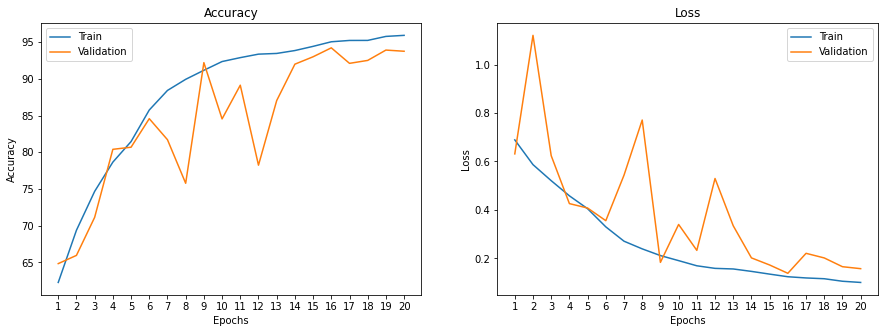

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history["train_acc"], label="Train")
plt.plot(range(1, epochs + 1), history["validation_acc"], label="Validation")
plt.xticks(range(1, epochs + 1))
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history["train_loss"], label="Train")
plt.plot(range(1, epochs + 1), history["validation_loss"], label="Validation")
plt.xticks(range(1, epochs + 1))
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

## 2.2 Train model with pre-trained weights

In [23]:
model_pretrained = models.resnet50(pretrained=True)
model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, 2)
model_pretrained = model_pretrained.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           factor=0.1, 
                                           patience=5, 
                                           verbose=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [24]:
epochs = 20
best_loss = np.inf
history = defaultdict(list)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss, train_acc = train_loop(train_loader, model_pretrained, loss_fn, optimizer)
    val_loss, val_acc = eval_loop(valid_loader, model_pretrained, loss_fn)
    
    scheduler.step(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model_pretrained.state_dict())

    print(f"[Train] Accuracy: {train_acc:>0.1f}%, Avg loss: {train_loss:>8f}")
    print(f"[Val]   Accuracy: {val_acc:>0.1f}%, Avg loss: {val_loss:>8f}")

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["validation_loss"].append(val_loss)
    history["validation_acc"].append(val_acc)

    print("")

model_pretrained.load_state_dict(best_model_wts)
print("Done!")

Epoch 1
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]


[Train] Accuracy: 92.2%, Avg loss: 0.185050
[Val]   Accuracy: 90.5%, Avg loss: 0.222001

Epoch 2
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]


[Train] Accuracy: 94.4%, Avg loss: 0.135136
[Val]   Accuracy: 92.6%, Avg loss: 0.163580

Epoch 3
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]


[Train] Accuracy: 95.7%, Avg loss: 0.104390
[Val]   Accuracy: 95.8%, Avg loss: 0.105703

Epoch 4
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]


[Train] Accuracy: 96.1%, Avg loss: 0.097951
[Val]   Accuracy: 95.3%, Avg loss: 0.109589

Epoch 5
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]


[Train] Accuracy: 96.3%, Avg loss: 0.095015
[Val]   Accuracy: 95.6%, Avg loss: 0.110791

Epoch 6
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]


[Train] Accuracy: 96.7%, Avg loss: 0.080647
[Val]   Accuracy: 94.8%, Avg loss: 0.137458

Epoch 7
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]


[Train] Accuracy: 97.0%, Avg loss: 0.076097
[Val]   Accuracy: 96.2%, Avg loss: 0.100072

Epoch 8
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]


[Train] Accuracy: 97.2%, Avg loss: 0.070037
[Val]   Accuracy: 96.6%, Avg loss: 0.099621

Epoch 9
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]


[Train] Accuracy: 97.5%, Avg loss: 0.064960
[Val]   Accuracy: 95.0%, Avg loss: 0.119840

Epoch 10
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]


[Train] Accuracy: 97.4%, Avg loss: 0.065075
[Val]   Accuracy: 95.5%, Avg loss: 0.106602

Epoch 11
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


[Train] Accuracy: 97.9%, Avg loss: 0.057534
[Val]   Accuracy: 96.2%, Avg loss: 0.095186

Epoch 12
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]


[Train] Accuracy: 97.4%, Avg loss: 0.062809
[Val]   Accuracy: 96.9%, Avg loss: 0.078787

Epoch 13
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


[Train] Accuracy: 98.0%, Avg loss: 0.053144
[Val]   Accuracy: 96.3%, Avg loss: 0.104886

Epoch 14
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


[Train] Accuracy: 97.9%, Avg loss: 0.053627
[Val]   Accuracy: 96.3%, Avg loss: 0.105653

Epoch 15
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


[Train] Accuracy: 97.9%, Avg loss: 0.052599
[Val]   Accuracy: 97.1%, Avg loss: 0.079076

Epoch 16
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]


[Train] Accuracy: 98.4%, Avg loss: 0.044082
[Val]   Accuracy: 96.7%, Avg loss: 0.096865

Epoch 17
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]


[Train] Accuracy: 98.1%, Avg loss: 0.047207
[Val]   Accuracy: 97.4%, Avg loss: 0.076000

Epoch 18
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]


[Train] Accuracy: 98.3%, Avg loss: 0.042157
[Val]   Accuracy: 97.0%, Avg loss: 0.089642

Epoch 19
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


[Train] Accuracy: 98.4%, Avg loss: 0.044537
[Val]   Accuracy: 97.2%, Avg loss: 0.077442

Epoch 20
-------------------------------


Eval  steps: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]

[Train] Accuracy: 98.7%, Avg loss: 0.035406
[Val]   Accuracy: 96.8%, Avg loss: 0.087827

Done!


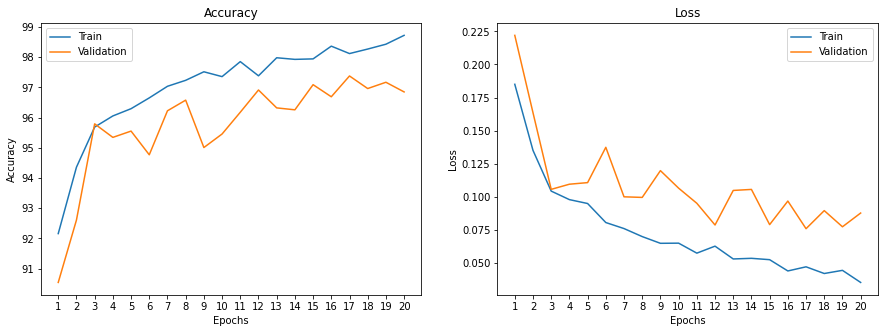

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history["train_acc"], label="Train")
plt.plot(range(1, epochs + 1), history["validation_acc"], label="Validation")
plt.xticks(range(1, epochs + 1))
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history["train_loss"], label="Train")
plt.plot(range(1, epochs + 1), history["validation_loss"], label="Validation")
plt.xticks(range(1, epochs + 1))
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()